In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [64]:
# Initial setup
TravelTs = np.array([6])  # Travel times; not necessarily seconds
reso = 50  # Resolution, interpretable as time length
A = np.array([32.5, 45, 57.5])  # Initial yields of the 3 patch types
a = np.array([0.075, 0.075, 0.075])  # Decay rates of the patch types
# pPatch = np.array([0.2, 0.3, 0.5])  # Proportions of patch types in a rich environment
pPatch = np.array([5/10, 3/10, 2/10])

NrPatchTypes = len(a)

# Arrays to store results
AllRewardE = np.zeros((reso, NrPatchTypes))
AllRRE = np.zeros((reso, NrPatchTypes))
AllGainE = np.zeros((reso, NrPatchTypes))

# Arrays to store multi-patch reward rates and optimal leaving times
multiPatchRR = np.zeros((reso, len(TravelTs), NrPatchTypes))
Tleave = np.zeros((len(TravelTs), NrPatchTypes), dtype=int)
RRleave = np.zeros((len(TravelTs), NrPatchTypes))

# Calculate rewards, reward rates, and gains
for P in range(NrPatchTypes):
    for T in range(1, reso + 1):
        RewardE = A[P] * np.exp(-a[P] * T)
        RRE = -a[P] * A[P] * np.exp(-a[P] * T)
        GainE = (A[P] / a[P]) * (1 - np.exp(-a[P] * T))
        
        AllRewardE[T - 1, P] = RewardE
        AllRRE[T - 1, P] = RRE
        AllGainE[T - 1, P] = GainE

    # Calculate optimal leaving times considering travel times for each patch type
    for Tind, TravelT in enumerate(TravelTs):
        RR = np.zeros(reso)
        for T in range(1, reso + 1):
            RR[T - 1] = AllGainE[T - 1, P] / (TravelT + T)
            multiPatchRR[T - 1, Tind, P] = RR[T - 1]
        
        Tleave[Tind, P] = np.argmax(RR)  # Determine optimal time to leave for each travel time and patch type
        RRleave[Tind, P] = np.max(RR)  # Store max RR for this travel time and patch type

# Printing results
for P in range(NrPatchTypes):
    print(f"Patch Type {P+1}:")
    for Tind in range(len(TravelTs)):
        print(f"  Travel Time {TravelTs[Tind]}: Optimal Leaving Time = {Tleave[Tind, P] + 1}, Max Reward Rate = {RRleave[Tind, P]:.2f}")

Patch Type 1:
  Travel Time 6: Optimal Leaving Time = 11, Max Reward Rate = 14.32
Patch Type 2:
  Travel Time 6: Optimal Leaving Time = 11, Max Reward Rate = 19.83
Patch Type 3:
  Travel Time 6: Optimal Leaving Time = 11, Max Reward Rate = 25.33


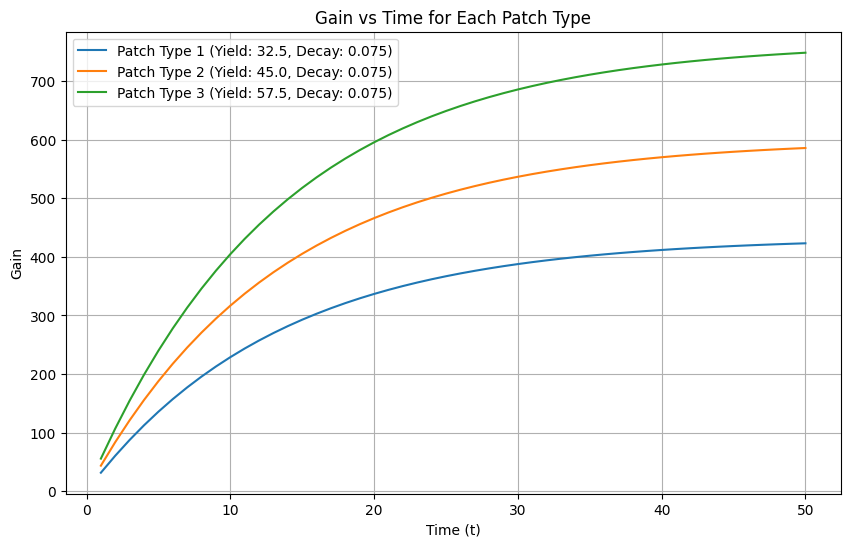

In [52]:
# Plotting
time_steps = np.arange(1, reso + 1)  # Time steps from 1 to reso
plt.figure(figsize=(10, 6))  # Set figure size
for P in range(NrPatchTypes):
    plt.plot(time_steps, AllGainE[:, P], label=f'Patch Type {P+1} (Yield: {A[P]}, Decay: {a[P]})')

plt.title('Gain vs Time for Each Patch Type')
plt.xlabel('Time (t)')
plt.ylabel('Gain')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
# Prepare to store results
OverallRR = np.zeros((reso, reso, reso, len(TravelTs)))
maxRR = np.zeros(len(TravelTs))
Tmax = np.zeros((len(TravelTs), 3), dtype=int)
GainEmax = np.zeros((len(TravelTs), 3))
RewardEmax = np.zeros((len(TravelTs), 3))

for Tind, TravelT in enumerate(TravelTs):
    Timesteps = np.arange(1, reso + 1) + TravelT  # Adjust time steps
    T1 = np.tile(Timesteps[:, np.newaxis, np.newaxis], (1, reso, reso))  # Extend and tile across dimensions
    T2 = np.tile(Timesteps[np.newaxis, :, np.newaxis], (reso, 1, reso))  # Extend and tile across dimensions
    T3 = np.tile(Timesteps[np.newaxis, np.newaxis, :], (reso, reso, 1))  # Extend and tile across dimensions

    # Compute proportions
    denominator = T1 * pPatch[0] + T2 * pPatch[1] + T3 * pPatch[2]
    proportionT1 = T1 * pPatch[0] / denominator
    proportionT2 = T2 * pPatch[1] / denominator
    proportionT3 = T3 * pPatch[2] / denominator

    # Replicate multiPatchRR across dimensions
    curPatchRR = np.zeros((reso, reso, reso, 3))
    curPatchRR[:, :, :, 0] = np.tile(multiPatchRR[:, Tind, 0][:, np.newaxis, np.newaxis], (1, reso, reso))
    curPatchRR[:, :, :, 1] = np.tile(multiPatchRR[:, Tind, 1][np.newaxis, :, np.newaxis], (reso, 1, reso))
    curPatchRR[:, :, :, 2] = np.tile(multiPatchRR[:, Tind, 2][np.newaxis, np.newaxis, :], (reso, reso, 1))

    # Calculate the overall reward rate
    OverallRR[:, :, :, Tind] = curPatchRR[:, :, :, 0] * proportionT1 \
                                + curPatchRR[:, :, :, 1] * proportionT2 \
                                + curPatchRR[:, :, :, 2] * proportionT3

    # Find the maximum reward rate and its index
    maxRR[Tind] = np.max(OverallRR[:, :, :, Tind])
    idx_max = np.argmax(OverallRR[:, :, :, Tind])
    Tmax[Tind] = np.unravel_index(idx_max, (reso, reso, reso))

    # Retrieve the maximum gain and reward
    GainEmax[Tind, :] = [AllGainE[Tmax[Tind][i], i] for i in range(3)]
    RewardEmax[Tind, :] = [AllRewardE[Tmax[Tind][i], i] for i in range(3)]

# Output results
print("Max Reward Rates:", maxRR)
print("Optimal Times (indices):", Tmax+1)
print("Gain at Max:", GainEmax)
print("Reward at Max:", RewardEmax)

Max Reward Rates: [18.56317312]
Optimal Times (indices): [[ 7 12 15]]
Gain at Max: [[176.99267544 356.05820416 517.76644169]]
Reward at Max: [[19.22554934 18.29563469 18.66751687]]


07/08

In [58]:
# Initial setup
def initialize_parameters(decay_type):
    TravelTs = np.array([6])  # Travel times; not necessarily seconds
    A = np.array([32.5, 45, 57.5])  # Initial yields of the 3 patch types
    if decay_type == 'exponential':
        reso = 50 # Resolution, interpretable as time length
        a = np.array([0.075, 0.075, 0.075])  # Decay rates of the patch types
    else:
        a = np.array([0.3, 0.3, 0.3])
        reso = 120 
    return TravelTs, reso, A, a

In [52]:
# Calculate rewards, reward rates, and gains
def calculate_rewards(A, a, T, decay_type='exponential'):
    if decay_type == 'exponential':
        Reward = A * np.exp(-a * T)
        RRE = -a * A * np.exp(-a * T)
        Gain = (A / a) * (1 - np.exp(-a * T))
    elif decay_type == 'linear':
        Reward = np.maximum(A - a * T, 0)
        RRE = -a
        Gain = A * T - 0.5 * a * T**2
    else:
        raise ValueError("Invalid decay type. Use 'exponential' or 'linear'.")
    return Reward, RRE, Gain

In [33]:
# Calculate optimal leaving times considering travel times for each patch type
def calculate_optimal_times(AllGain, TravelTs, reso, NrPatchTypes):
    multiPatchRR = np.zeros((reso, len(TravelTs), NrPatchTypes))
    Tleave = np.zeros((len(TravelTs), NrPatchTypes), dtype=int)
    RRleave = np.zeros((len(TravelTs), NrPatchTypes))

    for P in range(NrPatchTypes):
        for Tind, TravelT in enumerate(TravelTs):
            RR = np.zeros(reso)
            for T in range(1, reso + 1):
                RR[T - 1] = AllGain[T - 1, P] / (TravelT + T)
                multiPatchRR[T - 1, Tind, P] = RR[T - 1]
            Tleave[Tind, P] = np.argmax(RR)  # Determine optimal time to leave for each travel time and patch type
            RRleave[Tind, P] = np.max(RR)  # Store max RR for this travel time and patch type
    return multiPatchRR, Tleave, RRleave

In [34]:
# Compute overall reward rates
def compute_overall_rr(multiPatchRR, TravelTs, pPatch, reso, AllGainE, AllRewardE):
    NrPatchTypes = len(pPatch)
    OverallRR = np.zeros((reso, reso, reso, len(TravelTs)))
    maxRR = np.zeros(len(TravelTs))
    Tmax = np.zeros((len(TravelTs), 3), dtype=int)
    GainEmax = np.zeros((len(TravelTs), 3))
    RewardEmax = np.zeros((len(TravelTs), 3))

    for Tind, TravelT in enumerate(TravelTs):
        Timesteps = np.arange(1, reso + 1) + TravelT  # Adjust time steps
        T1 = np.tile(Timesteps[:, np.newaxis, np.newaxis], (1, reso, reso))  # Extend and tile across dimensions
        T2 = np.tile(Timesteps[np.newaxis, :, np.newaxis], (reso, 1, reso))  # Extend and tile across dimensions
        T3 = np.tile(Timesteps[np.newaxis, np.newaxis, :], (reso, reso, 1))  # Extend and tile across dimensions

        # Compute proportions
        denominator = T1 * pPatch[0] + T2 * pPatch[1] + T3 * pPatch[2]
        proportionT1 = T1 * pPatch[0] / denominator
        proportionT2 = T2 * pPatch[1] / denominator
        proportionT3 = T3 * pPatch[2] / denominator

        # Replicate multiPatchRR across dimensions
        curPatchRR = np.zeros((reso, reso, reso, 3))
        curPatchRR[:, :, :, 0] = np.tile(multiPatchRR[:, Tind, 0][:, np.newaxis, np.newaxis], (1, reso, reso))
        curPatchRR[:, :, :, 1] = np.tile(multiPatchRR[:, Tind, 1][np.newaxis, :, np.newaxis], (reso, 1, reso))
        curPatchRR[:, :, :, 2] = np.tile(multiPatchRR[:, Tind, 2][np.newaxis, np.newaxis, :], (reso, reso, 1))

        # Calculate the overall reward rate
        OverallRR[:, :, :, Tind] = curPatchRR[:, :, :, 0] * proportionT1 \
                                   + curPatchRR[:, :, :, 1] * proportionT2 \
                                   + curPatchRR[:, :, :, 2] * proportionT3

        # Find the maximum reward rate and its index
        maxRR[Tind] = np.max(OverallRR[:, :, :, Tind])
        idx_max = np.argmax(OverallRR[:, :, :, Tind])
        Tmax[Tind] = np.unravel_index(idx_max, (reso, reso, reso))

        # Retrieve the maximum gain and reward
        GainEmax[Tind, :] = [AllGainE[Tmax[Tind][i], i] for i in range(3)]
        RewardEmax[Tind, :] = [AllRewardE[Tmax[Tind][i], i] for i in range(3)]

        # Output results
        print("Max Reward Rates:", maxRR)
        print("Optimal Times (indices):", Tmax+1)
        print("Gain at Max:", GainEmax)
        print("Reward at Max:", RewardEmax)

    return maxRR, Tmax, GainEmax, RewardEmax

In [55]:
# Function to plot Gain vs Time for each patch type
def plot_gain_vs_time(AllGainE, A, a, reso):
    patch_labels = ['Low', 'Med', 'High']
    time_steps = np.arange(1, reso + 1)  # Time steps from 1 to reso
    plt.figure(figsize=(6, 4))  # Set figure size
    for P in range(len(A)):
        plt.plot(time_steps, AllGainE[:, P], label=f'{patch_labels[P]} (Yield: {A[P]}, Decay: {a[P]})')

    plt.title('Gain vs Time for Each Patch Type')
    plt.xlabel('Time (t)')
    plt.ylabel('Gain')
    plt.legend()
    plt.show()

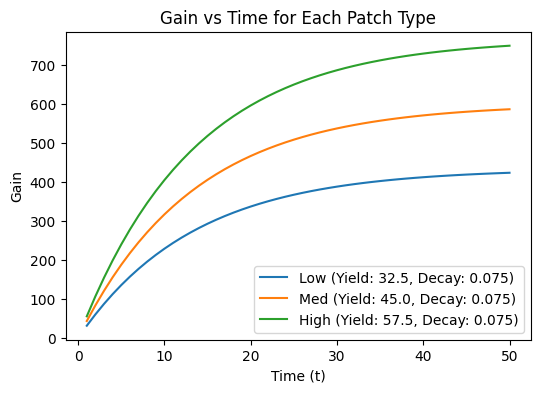

Max Reward Rates: [21.86779076]
Optimal Times (indices): [[ 5 10 13]]
Gain at Max: [[135.50797919 316.58006836 477.48586227]]
Reward at Max: [[22.33690156 21.25649487 21.68856033]]
Max Reward Rates: [18.56317312]
Optimal Times (indices): [[ 7 12 15]]
Gain at Max: [[176.99267544 356.05820416 517.76644169]]
Reward at Max: [[19.22554934 18.29563469 18.66751687]]


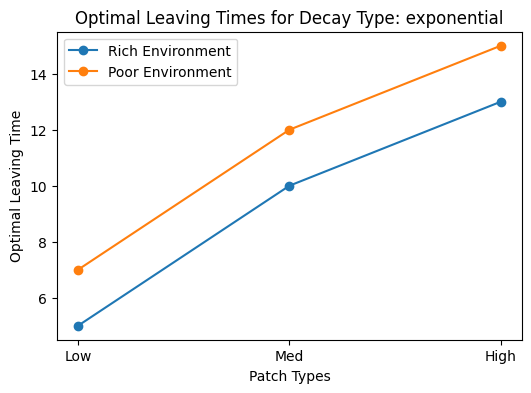

In [59]:
# Main function to run the analysis and plot results
def main(decay_type='exponential'):
    TravelTs, reso, A, a = initialize_parameters(decay_type)
    NrPatchTypes = len(a)

    # Define proportions for rich and poor environments
    rich_proportions = np.array([0.2, 0.3, 0.5])
    poor_proportions = np.array([0.5, 0.3, 0.2])

    # Arrays to store results
    AllRewardE = np.zeros((reso, NrPatchTypes))
    AllRRE = np.zeros((reso, NrPatchTypes))
    AllGainE = np.zeros((reso, NrPatchTypes))

    # Calculate rewards, reward rates, and gains
    for P in range(NrPatchTypes):
        for T in range(1, reso + 1):
            RewardE, RRE, GainE = calculate_rewards(A[P], a[P], T, decay_type)
            AllRewardE[T - 1, P] = RewardE
            AllRRE[T - 1, P] = RRE
            AllGainE[T - 1, P] = GainE

    # Plot Gain vs Time
    plot_gain_vs_time(AllGainE, A, a, reso)
    
    # Calculate optimal leaving times for rich environment
    multiPatchRR_rich, Tleave_rich, RRleave_rich = calculate_optimal_times(AllGainE, TravelTs, reso, NrPatchTypes)
    maxRR_rich, Tmax_rich, GainEmax_rich, RewardEmax_rich = compute_overall_rr(multiPatchRR_rich, TravelTs, rich_proportions, reso, AllGainE, AllRewardE)

    # Calculate optimal leaving times for poor environment
    multiPatchRR_poor, Tleave_poor, RRleave_poor = calculate_optimal_times(AllGainE, TravelTs, reso, NrPatchTypes)
    maxRR_poor, Tmax_poor, GainEmax_poor, RewardEmax_poor = compute_overall_rr(multiPatchRR_poor, TravelTs, poor_proportions, reso, AllGainE, AllRewardE)

    # Plot results
    patch_types = ['Low', 'Med', 'High']

    fig, ax = plt.subplots(figsize=(6, 4))

    # Plot for Rich Environment
    ax.plot(patch_types, Tmax_rich[0] + 1, marker='o', label='Rich Environment')

    # Plot for Poor Environment
    ax.plot(patch_types, Tmax_poor[0] + 1, marker='o', label='Poor Environment')

    # Adding labels and title
    ax.set_xlabel('Patch Types')
    ax.set_ylabel('Optimal Leaving Time')
    ax.set_title(f'Optimal Leaving Times for Decay Type: {decay_type}')
    ax.legend()

    plt.show()

# Run the main function
main(decay_type='exponential')  # Change to 'linear' for linear decay

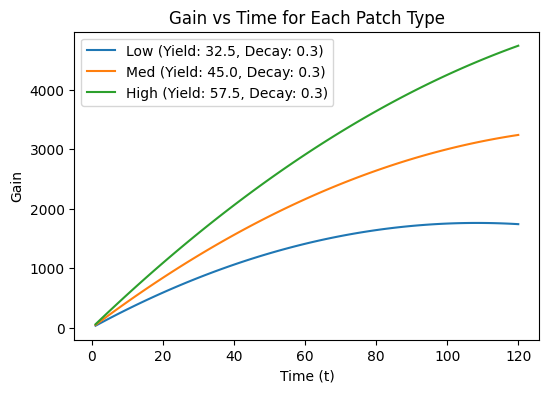

Max Reward Rates: [40.66276042]
Optimal Times (indices): [[ 1 14 56]]
Gain at Max: [[  32.35  600.6  2749.6 ]]
Reward at Max: [[32.2 40.8 40.7]]
Max Reward Rates: [35.23685897]
Optimal Times (indices): [[ 1 33 74]]
Gain at Max: [[  32.35 1321.65 3433.6 ]]
Reward at Max: [[32.2 35.1 35.3]]


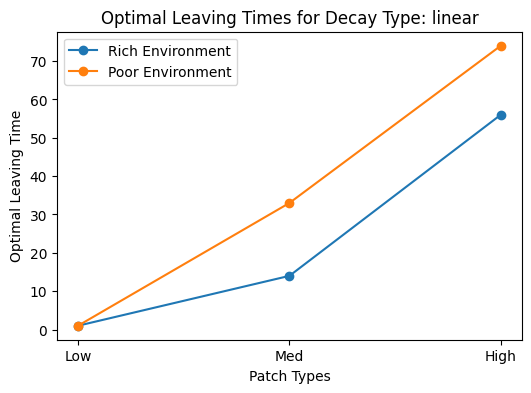

In [60]:
main(decay_type='linear')